In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy
import seaborn as sns
import surprise

from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from surprise import SVD
from surprise import Dataset, Reader
from surprise.model_selection import cross_validate, train_test_split, RandomizedSearchCV, split

In [5]:
ratings_path = os.path.join(os.getcwd(), os.path.join('ml-latest-small', 'ratings.csv'))
data = pd.read_csv(ratings_path).drop(["timestamp"], axis=1)

## Train test split

In [6]:
def split_dataset(X, test_frac=0.1):
    test_set_size = int(X.shape[0]*test_frac)
    test_idx = np.random.choice(X.index, size=test_set_size, replace=False)
    test_set = X.loc[test_idx, :]
    train_set = X.copy()
    train_set.loc[test_idx, "rating"] = np.NaN
    return train_set, test_set.sort_values(by=["userId", "movieId"]), test_idx

X_train, X_test, test_idx = split_dataset(data)
util_matrix = X_train.pivot(index='userId', columns='movieId')

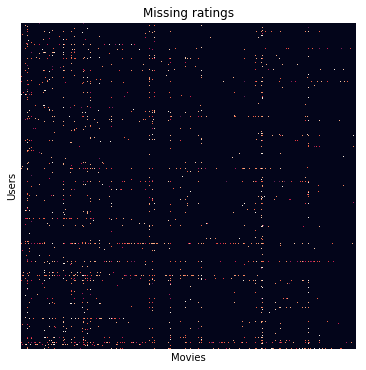

In [7]:
fig, ax = plt.subplots(1, 1, figsize = (6, 6))

cmap = sns.color_palette("YlGnBu", len(data["rating"].unique()))
sns.heatmap(util_matrix.fillna(-1), 
            yticklabels=False, 
            xticklabels=False, 
            #cmap=cmap,
            cbar=False, 
            ax=ax)

ax.set_title('Missing ratings')
ax.set_xlabel('Movies')
ax.set_ylabel('Users');

## Data imputation

In [28]:
def adjust_to_mean(df, util_matrix, col):
    group_means = df.groupby(col).aggregate(np.mean)
    util_copy = util_matrix.copy()
    for col in util_copy.columns:
        util_copy.loc[:, col] = group_means.values
    return util_copy

user_avg_ratings = adjust_to_mean(X_train.drop('movieId', axis=1), util_matrix, 'userId')
movie_avg_ratings = adjust_to_mean(X_train.drop('userId', axis=1), util_matrix.T, 'movieId').T
grand_mean = data.loc[:, "rating"].mean()

mean_adjusted_ratings = user_avg_ratings + movie_avg_ratings - grand_mean
util_matrix_filled = util_matrix.mask(np.isnan, other=mean_adjusted_ratings)
util_matrix_filled = util_matrix_filled.mask(np.isnan, other=grand_mean)

### Dummy classifier

In [29]:
mean_movie_rating = X_train["rating"].mean()
dummy_prediction = np.full(X_test["rating"].shape, mean_movie_rating)
dummy_rse = mean_squared_error(X_test["rating"], dummy_prediction)
dummy_rse**(1/2)

1.0446156469268717

### Mean adjusted classifier

In [30]:
def get_rse(prediction, test_set):
    ratings_comparison = prediction.merge(test_set, on=["userId", "movieId"]).loc[:, ["rating_x", "rating_y"]]
    error = mean_squared_error(ratings_comparison["rating_x"], 
                               ratings_comparison["rating_y"])
    return error ** (1/2)

In [31]:
mean_adj_rse = get_rse(util_matrix_filled.stack().reset_index(), X_test)
mean_adj_rse

0.9067929180262044

### NMF

In [32]:
epsilon = 10e-4
nmf_offset = abs(np.min(util_matrix_filled.values)) + epsilon
nmf_model = NMF(init='random' , random_state=0)

rse_info = {}
# n_components <= min(132, 4841)
for n_components in range(10, 40, 5):
    nmf_model.n_components = n_components
    W = nmf_model.fit_transform(util_matrix_filled + nmf_offset)
    H = nmf_model.components_
    X_approx = np.dot(W,H) - nmf_offset
    X_approx = pd.DataFrame(X_approx, columns=util_matrix.columns, index=util_matrix.index)
    rse_info[n_components] = get_rse(X_approx.stack().reset_index(), X_test)

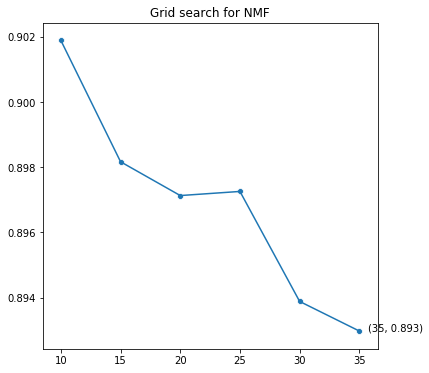

In [33]:
rse_series = pd.Series(rse_info)
fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.lineplot(data=pd.Series(rse_series), label="line", ax=ax)
sns.scatterplot(data=rse_series)

min_idx = rse_series.idxmin()
min_nmf = rse_series.min()
ax.text(min_idx+.7, min_nmf, str((min_idx, round(min_nmf, 3))))

ax.legend_.remove()
ax.set_title('Grid search for NMF')
ax;

## SVD

In [34]:
svd = TruncatedSVD(random_state=42)

svd_dict = {}
for n_components in range(8, 30, 2):
    svd.n_components = n_components
    svd.fit(util_matrix_filled)
    sigma = np.diag(svd.singular_values_)
    VT = svd.components_
    W = svd.transform(util_matrix_filled)/svd.singular_values_
    H = np.dot(sigma ,VT)
    svd_prediction = W @ H
    svd_prediction = pd.DataFrame(svd_prediction, 
                                  columns=util_matrix_filled.columns, 
                                  index=util_matrix_filled.index)
    svd_dict[n_components] = [get_rse(svd_prediction.stack(), X_test), 
                              svd.explained_variance_ratio_.sum()]

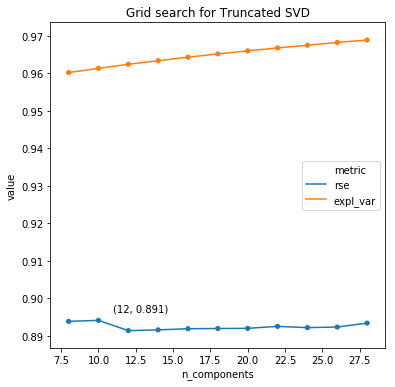

In [35]:
svd_df = pd.DataFrame.from_dict(svd_dict)
min_idx = svd_df.loc[0, :].idxmin()
min_svd = svd_df.loc[0, :].min()

svd_df["value"] = ["rse", "expl_var"]
svd_df.set_index("value", inplace=True)
svd_df = svd_df.T.stack().reset_index()
svd_df.columns = ["n_components", "metric", "value"]

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
sns.lineplot(x="n_components", y="value", hue="metric", data=svd_df, ax=ax)
sns.scatterplot(x="n_components", y="value", hue="metric", data=svd_df, ax=ax, legend=False)

ax.text(min_idx-1, min_svd+0.005, str((min_idx, round(min_svd, 3))))
ax.set_title('Grid search for Truncated SVD');

### Dummy classifier with surpsise

In [16]:
from surprise import AlgoBase

class DummyRecommender(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.global_mean = trainset.global_mean
        return self

    def estimate(self, u, i):
        return self.global_mean
    
cross_validate(DummyRecommender(), data_surp, verbose=True, cv=cv)

Evaluating RMSE, MAE of algorithm DummyRecommender on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0431  1.0383  1.0382  1.0399  0.0023  
MAE (testset)     0.8259  0.8194  0.8224  0.8226  0.0027  
Fit time          0.02    0.04    0.04    0.04    0.01    
Test time         0.03    0.10    0.03    0.05    0.03    


{'fit_time': (0.022330760955810547, 0.04292702674865723, 0.044764041900634766),
 'test_mae': array([0.82591394, 0.81942166, 0.82243238]),
 'test_rmse': array([1.04310594, 1.03834969, 1.03821183]),
 'test_time': (0.029151439666748047, 0.1022489070892334, 0.028337955474853516)}

In [17]:
from surprise import AlgoBase


def adjust_to_mean(df, util_matrix, col):
    group_means = df.groupby(col).aggregate(np.mean)
    util_copy = util_matrix.copy()
    for col in util_copy.columns:
        util_copy.loc[:, col] = group_means.values.reshape(-1)
    return util_copy

class MeanAdjustedRecommender(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def fit(self, trainset):
        AlgoBase.fit(self, trainset)
        self.global_mean = trainset.global_mean
        
        dataset = np.array([[uid, iid, r] for (uid, iid, r) in trainset.all_ratings()]).reshape((-1, 3))
        dataset = pd.DataFrame(dataset, columns=['userId', 'movieId', 'rating'])
        dataset = dataset.astype({'userId': 'int32', 'movieId':'int32'})
        
        util_matrix = dataset.pivot(index='userId', columns='movieId')
        user_avg_ratings = adjust_to_mean(dataset.drop('movieId', axis=1), util_matrix, 'userId')
        movie_avg_ratings = adjust_to_mean(dataset.drop('userId', axis=1), util_matrix.T, 'movieId').T
        self.mean_adj_matrix =  user_avg_ratings + movie_avg_ratings - self.global_mean
        
        return self

    def estimate(self, u, i):
        if self.trainset.knows_user(u) and self.trainset.knows_item(i):
            return self.mean_adj_matrix.iloc[u, i]
        return self.global_mean
    
mean_adj_recommender = MeanAdjustedRecommender()
cross_validate(MeanAdjustedRecommender(), data_surp, verbose=True, cv=cv)

Evaluating RMSE, MAE of algorithm MeanAdjustedRecommender on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9226  0.9188  0.9195  0.9203  0.0017  
MAE (testset)     0.7048  0.7000  0.7001  0.7016  0.0023  
Fit time          6.38    6.39    6.40    6.39    0.01    
Test time         0.60    0.60    0.60    0.60    0.00    


{'fit_time': (6.380048990249634, 6.3915746212005615, 6.395204305648804),
 'test_mae': array([0.70481419, 0.6999786 , 0.7000901 ]),
 'test_rmse': array([0.92262942, 0.91875943, 0.91946632]),
 'test_time': (0.6019554138183594, 0.596137285232544, 0.5979757308959961)}

### SGD-Based SVD

In [15]:
reader = Reader()
data_surp = Dataset.load_from_df(data, reader)

# lr_all – The learning rate for all parameters. Default is 0.005.
# reg_all – The regularization term for all parameters. Default is 0.02
param_grid = {'n_epochs': [5, 10, 20, 30], 
              'lr_all': [0.007, 0.009, 0.01],
              'reg_all': [0.05, 0.1, 0.2, 0.4]}

cv = split.ShuffleSplit(n_splits=3, test_size=0.1, shuffle=True)
gs =  RandomizedSearchCV(SVD, 
                         param_grid, 
                         measures=['rmse'], 
                         cv=cv,
                         return_train_measures=True,
                         refit=True,
                         n_iter=15, 
                         n_jobs=3)
gs.fit(data_surp)
svd_sgd = gs.best_estimator

In [ ]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

#0.8541955377814917
#{'n_epochs': 20, 'lr_all': 0.009, 'reg_all': 0.05}

In [ ]:
cross_validate(svd_sgd['rmse'], data_surp, verbose=True, cv=cv)

## Models comparison

In [ ]:
comparison = {"Dummy": dummy_rse, 
              "Mean Adj": mean_adj_rse,  
              "NMF": min_nmf, 
              "SVD": min_svd}
pd.Series(comparison).round(5)